## RAG with Milvus, Llama 3 and Llama-Index

Use RAG to force the LLM to work with your data by injecting it via a vector database like Milvus

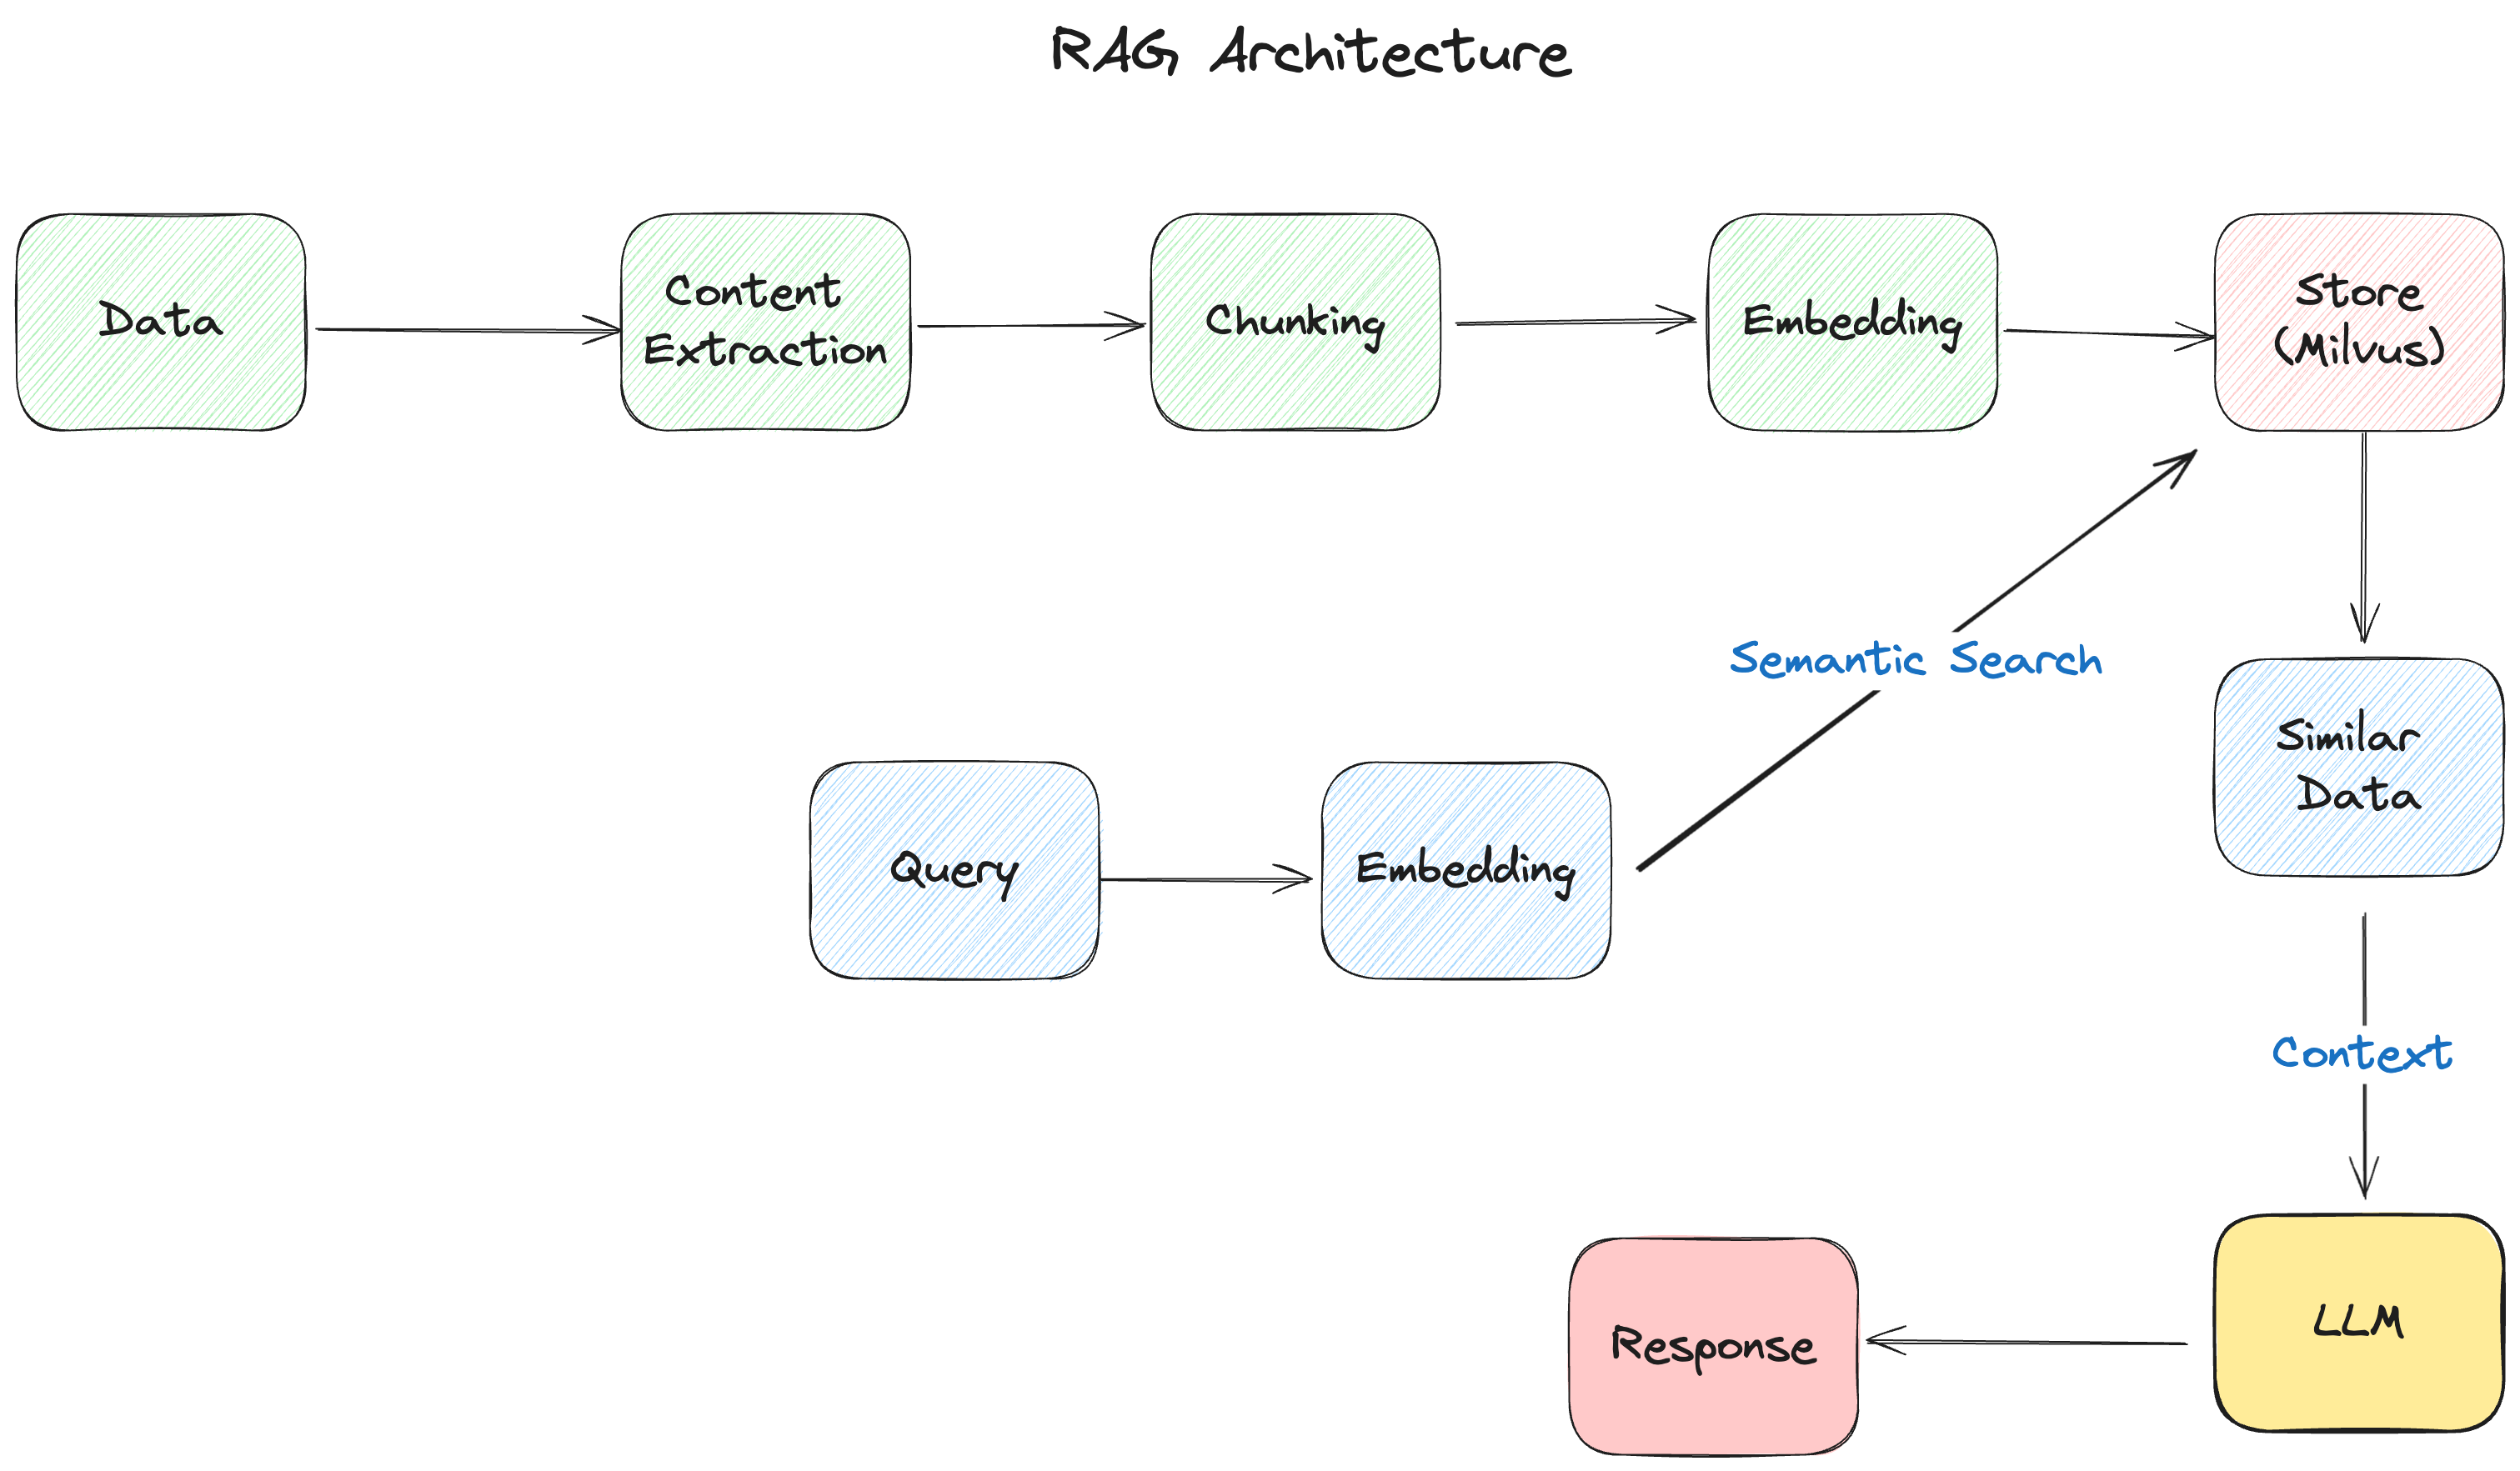

# Install Milvus Lite

In [26]:
!pip install -U pymilvus

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


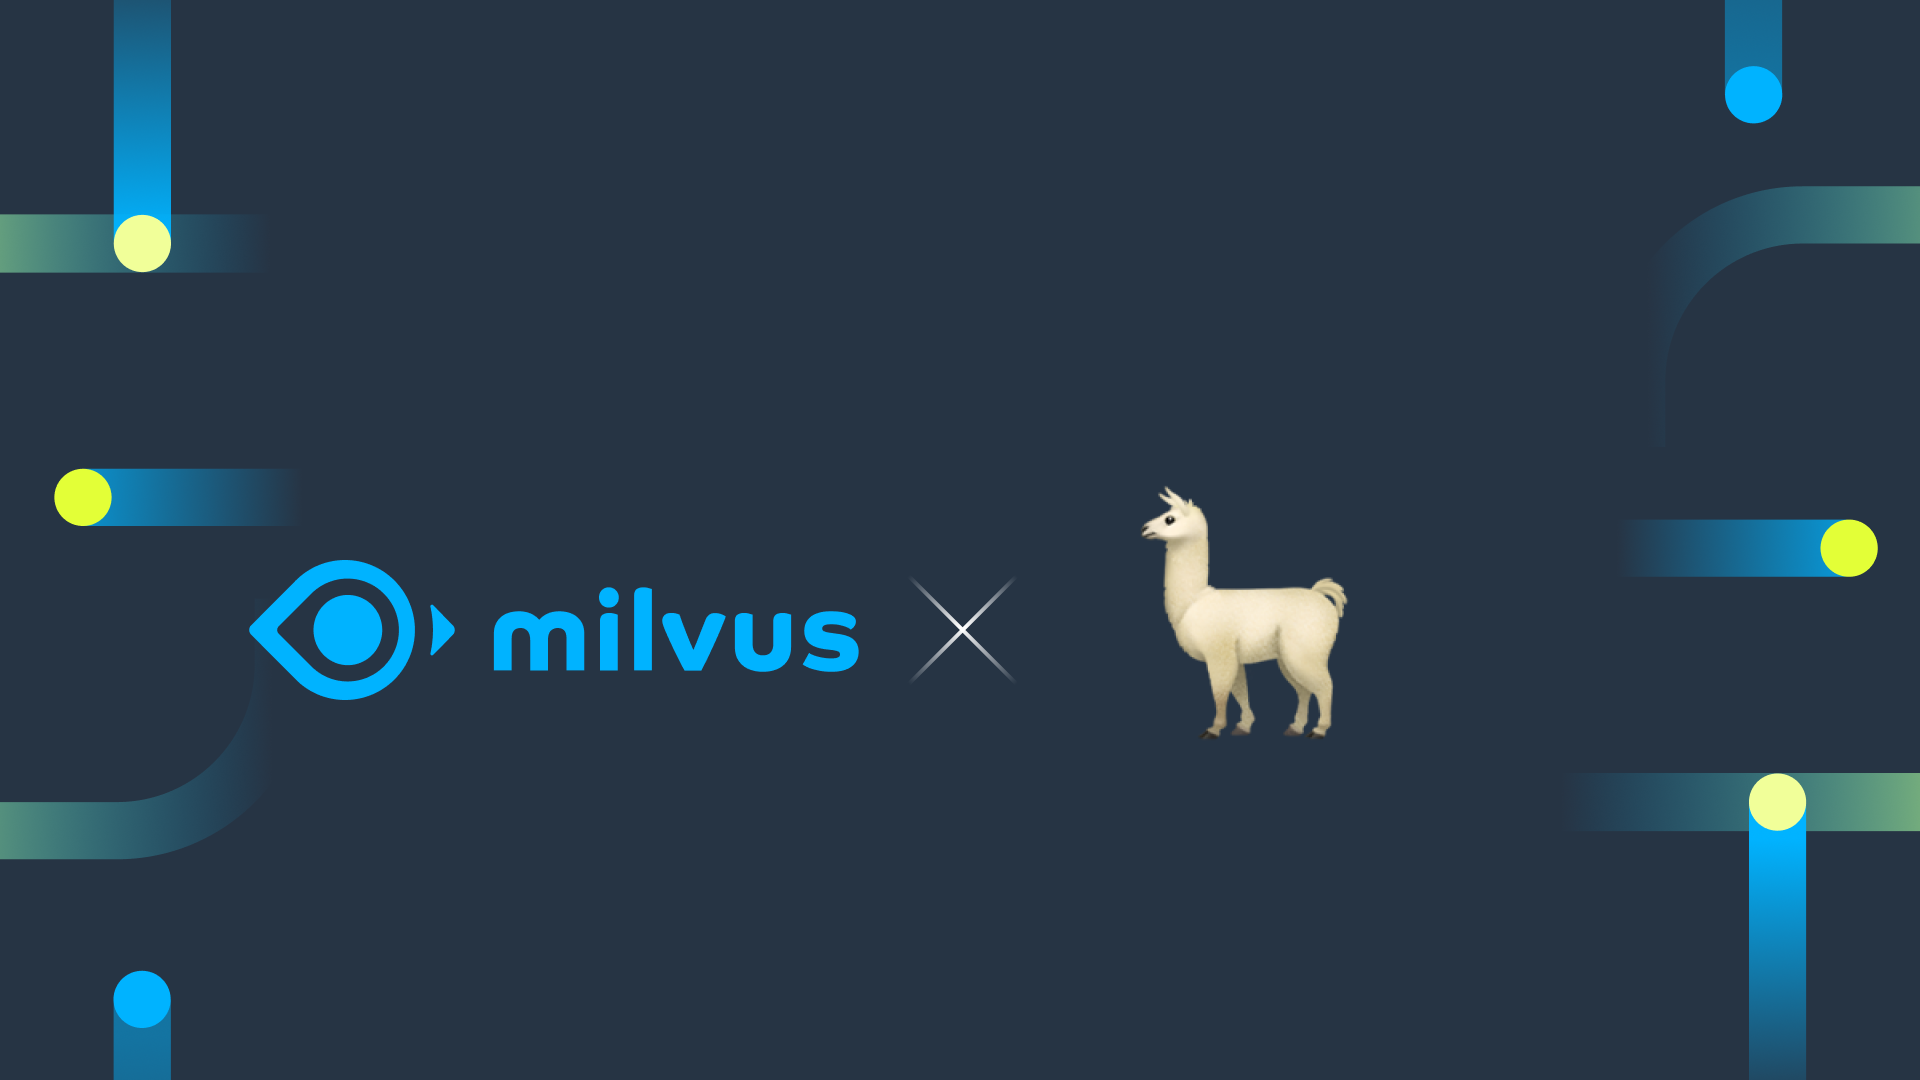

## Install other dependencies

In [27]:
!pip install -U llama-index-embeddings-jinaai llama-index-readers-file ollama llama-index-llms-ollama llama-index-vector-stores-milvus wget

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [28]:
!pip install sentence-transformers llama-index-embeddings-huggingface

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


### Load Jina AI Embedding Model

In [29]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


jina_embedding_model = HuggingFaceEmbedding(model_name="jinaai/jina-embeddings-v2-base-en")
len(jina_embedding_model.get_text_embedding('This is a test'))

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

768

## Get and Load Data 

In [30]:
! wget 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0001813756/975b3e9b-268e-4798-a9e4-2a9a7c92dc10.pdf' -O 'wework.pdf'

--2024-07-15 16:17:24--  https://d18rn0p25nwr6d.cloudfront.net/CIK-0001813756/975b3e9b-268e-4798-a9e4-2a9a7c92dc10.pdf
Resolving d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)... 108.156.253.15, 108.156.253.133, 108.156.253.201, ...
Connecting to d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)|108.156.253.15|:443... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


connected.
HTTP request sent, awaiting response... 200 OK
Length: 5374661 (5.1M) [application/pdf]
Saving to: ‘wework.pdf’

wework.pdf          100%[===================>]   5.12M  26.4MB/s    in 0.2s    

2024-07-15 16:17:25 (26.4 MB/s) - ‘wework.pdf’ saved [5374661/5374661]



## Chunking
Load the data and create chunks

In [31]:
from llama_index.core import SimpleDirectoryReader

docs = SimpleDirectoryReader(input_files=["wework.pdf"]).load_data()

In [32]:
len(docs)

169

### Chunk size 100, Overlap 20

In [33]:
from llama_index.core.node_parser import SentenceSplitter

base_splitter = SentenceSplitter(chunk_size=100, chunk_overlap=20)
base_nodes = base_splitter.get_nodes_from_documents(docs)

for elt in base_nodes[5:10]:
    print(f'element is: {elt.get_content()}\n')

element is: of the Securities Exchange Act of 1934 during the preceding 12 months (or for such shorter period that the registrant was required to file
such reports); and (2) has been subject to such filing requirements for the past 90 days.    Yes  x    No  o
Indicate by check mark whether the registrant has submitted electronically and posted on its corporate web site, if any,

element is: if any, every Interactive Data File required to be submitted and posted pursuant to Rule 405 of Regulation S-T (§232.405 of this chapter)
during the preceding 12 months (or for such shorter period that the registrant was required to submit and post such files).Yes  x   No  o 
Indicate by check mark whether the registrant is a large accelerated filer, an accelerated filer,

element is: an accelerated filer, a non-accelerated filer, or a smaller reporting company. See the definitions of “large accelerated filer,” “accelerated filer” and “smaller reporting company”
in Rule 12b-2 of the Exchange Act.

e

# Load data in Milvus

In [34]:
import os 

from llama_index.llms.ollama import Ollama
from llama_index.vector_stores.milvus import MilvusVectorStore

from llama_index.core import StorageContext, ServiceContext
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex

from llama_index.embeddings.jinaai import JinaEmbedding

llm = Ollama(model="llama3", request_timeout=120.0)

jina_embedding_model = HuggingFaceEmbedding(model_name="jinaai/jina-embeddings-v2-base-en")

service_context_jina = ServiceContext.from_defaults(llm=llm, embed_model=jina_embedding_model, chunk_size=512, chunk_overlap=100)

vector_store_jina = MilvusVectorStore(
    uri="milvus_rag_llama_index.db",
    collection_name="wework_data",
    dim=768,  # the value changes with embedding model
    overwrite=True  # drop table if exist and then create
    )
storage_context_jina = StorageContext.from_defaults(vector_store=vector_store_jina)

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

In [35]:
docs = SimpleDirectoryReader(input_files=["wework.pdf"]).load_data()

In [36]:
vector_index_jina = VectorStoreIndex.from_documents(docs, storage_context=storage_context_jina, service_context=service_context_jina)

In [37]:
from llama_index.core.tools import RetrieverTool, ToolMetadata

milvus_tool_openai = RetrieverTool(
    retriever=vector_index_jina.as_retriever(similarity_top_k=3),  # retrieve top_k results
    metadata=ToolMetadata(
        name="CustomRetriever",
        description='Retrieve relevant information from provided documents.'
    ),
)

In [38]:
query_engine = vector_index_jina.as_query_engine()
response = query_engine.query("Can you tell me about WeWork, what they do and who they are?")
print(response)

WeWork is a company that provides shared workspace and services for entrepreneurs, freelancers, startups, and other professionals. They offer a range of spaces, from private offices to community workspaces, as well as amenities such as high-speed internet, printers, and meeting rooms.

As for who they are, WeWork is a global company with a presence in over 120 cities across more than 28 countries. They have become one of the largest commercial real estate companies in the world, with a portfolio of properties that includes office buildings, apartments, and other types of spaces.

WeWork has received funding from investors such as SoftBank Group, which owns a significant stake in the company. This has enabled WeWork to expand its operations and offer new services to its members.

In addition to providing shared workspace, WeWork also offers a range of tools and resources to help entrepreneurs and small businesses succeed. These include mentorship programs, networking events, and access 

In [39]:
query_engine = vector_index_jina.as_query_engine()
response = query_engine.query("What are the Risk Factors for WeWork that could happen?")
print(response)

The risk factors that could impact WeWork include a lack of assurance in improving its liquidity position and profitability, which may lead to considering all strategic alternatives, including restructuring or refinancing debt, seeking additional capital, reducing or delaying business activities, selling assets, or obtaining relief under the U.S. Bankruptcy Code. Additionally, there is also a risk that the perception of WeWork's uncertain financial situation could deter members, landlords, and others from doing business with it, causing concerns about its ability to meet contractual obligations. Furthermore, if WeWork seeks additional financing, there may be substantial doubt about its ability to continue as a going concern, which could affect access to funding on commercially reasonable terms or at all.
